# MLOps Zoomcamp - 01 Intro - Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

### 1.  Importing Python libraries

In [1]:
# !pip install pandas
# !pip install scikit-learn
# !pip install tqdm
# !pip install seaborn
# !pip install pyarrow

In [21]:
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### 2. Data Ingestion

* Data is read from the URL: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* We'll use the 'Yellow Taxi Trip Records' datasets for NYC taxis from January and February 2023

In [3]:
df_jan23 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df_feb23 = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

### Q1. Downloading the data
**Read the data for January. How many columns are there?**

In [4]:
df_jan23.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [5]:
no_columns = len(df_jan23.columns)
print(f"Total Columns: {no_columns}")

Total Columns: 19


### Q2. Computing duration
**Now let's compute the duration variable. It should contain the duration of a ride in minutes**

**What's the standard deviation of the trips duration in January?**

In [6]:
df_jan23["duration"] = df_jan23['tpep_dropoff_datetime'] - df_jan23['tpep_pickup_datetime']
df_jan23['duration'] = df_jan23["duration"].progress_apply(lambda td: td.total_seconds()/60)

standard_deviation = df_jan23["duration"].std()

print(f"Standard Deviation of the trips duration in January: {standard_deviation}")

100%|██████████| 3066766/3066766 [00:13<00:00, 235778.01it/s]

Standard Deviation of the trips duration in January: 42.59435124195458


### Q3. Dropping outliers
**Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).**

<Axes: xlabel='duration'>

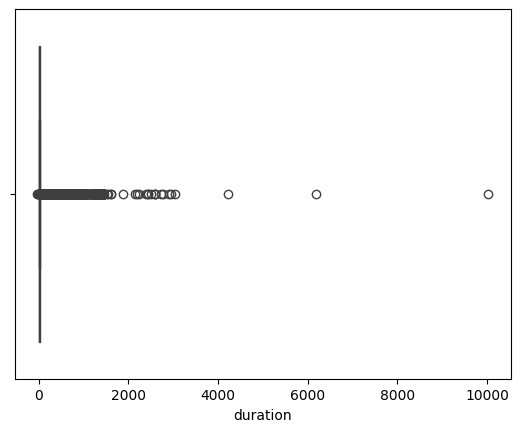

In [7]:
sns.boxplot(x=df_jan23["duration"])

In [8]:
before = df_jan23.duration.count()

In [9]:
df_jan23_without_outliers = df_jan23[(df_jan23.duration >=1) & (df_jan23.duration <=60)]

<Axes: xlabel='duration'>

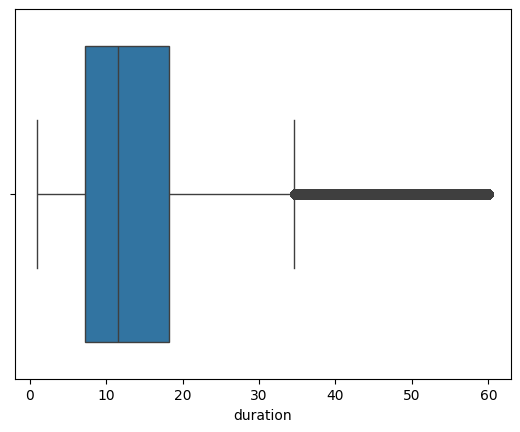

In [10]:
sns.boxplot(x=df_jan23_without_outliers["duration"])

In [11]:
after = df_jan23_without_outliers.duration.count()

**What fraction of the records left after you dropped the outliers?**

In [12]:
fraction = (after / before) * 100
print(f"Fraction: {fraction} %")

Fraction: 98.1220282212598 %


### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
* Fit a dictionary vectorizer
* Get a feature matrix from it

In [13]:
df_jan23_without_outliers[['PULocationID', 'DOLocationID']] = df_jan23_without_outliers[['PULocationID', 'DOLocationID']].astype(str)  

dv = DictVectorizer()
train_dicts = df_jan23_without_outliers[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts) 

**What's the dimensionality of this matrix (number of columns)?**

In [14]:
dimension = X_train.shape[1]

print(f"Dimensionality of matrix (number of columns): {dimension}")

Dimensionality of matrix (number of columns): 515


### Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters
* Calculate the RMSE of the model on the training data

In [16]:
target = 'duration'
y_train = df_jan23_without_outliers[target].values
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [22]:
#RMSE = mean_squared_error(y_train, y_pred, squared=False)
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))

**¿What's the RMSE on train?**

In [23]:
print(f"RMSE on train: {RMSE}")

RMSE on train: 7.649261931416412


### Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

In [24]:
df_feb23["duration"] = df_feb23['tpep_dropoff_datetime'] - df_feb23['tpep_pickup_datetime']
df_feb23['duration'] = df_feb23["duration"].progress_apply(lambda td: td.total_seconds()/60)

df_feb23_without_outliers = df_feb23[(df_feb23.duration >=1) & (df_feb23.duration <=60)]

df_feb23_without_outliers[['PULocationID', 'DOLocationID']] = df_feb23_without_outliers[['PULocationID', 'DOLocationID']].astype(str)  
validation_dicts = df_feb23_without_outliers[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_validation = dv.transform(validation_dicts)

y_validation = df_feb23_without_outliers['duration'].values
y_prediction = model.predict(X_validation)
#RMSE_validation = mean_squared_error(y_validation, y_prediction, squared=False)
RMSE_validation = np.sqrt(mean_squared_error(y_validation, y_prediction))

100%|██████████| 2913955/2913955 [00:15<00:00, 184971.97it/s]


**¿What's the RMSE on validation?**

In [25]:
print(f"RMSE on validation: {RMSE_validation}")

RMSE on validation: 7.8118162035401735
